<a href="https://colab.research.google.com/github/Haymanot-Demis/NewLearningTrack/blob/main/Clear%20Sight%20Single%20Output%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Clear Sight**
  A model capable of detecting trachoma in its initial stages, offering a vital window for timely medical intervention

In [1]:
# mouting google drive so that we could be able to access the files there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importing python libraries
import tensorflow as tf
from tensorflow.keras import utils
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import time

from tensorflow.keras.applications import vgg16

physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
dir_name = "drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset"
filenames = list(os.listdir(dir_name))
filenames.sort()

In [4]:
# number of files in the folder including the label csv file
len(filenames)

1657

In [5]:
# getting the label csv file
label_csv = filenames.pop()

In [6]:
label_csv

'tfti.csv'

In [7]:
image_paths = []
label_csv_path = dir_name + "/" + label_csv

for fn in filenames:
  image_paths.append(dir_name + "/" + fn)

image_paths[:10], label_csv_path

(['drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image10.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image100.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1000.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1001.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1002.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1003.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1004.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1005.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1006.jpg'],
 'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/tfti.csv')

In [8]:
# read the labels from the csv file
labels = pd.read_csv(label_csv_path)

# 5 labels
labels.iloc[0], labels.iloc[9], labels.iloc[99], labels.iloc[999]

(key    1
 TF     0
 TI     0
 Name: 0, dtype: int64,
 key    10
 TF      1
 TI      1
 Name: 9, dtype: int64,
 key    100
 TF       0
 TI       0
 Name: 99, dtype: int64,
 key    1000
 TF        0
 TI        0
 Name: 999, dtype: int64)


>**Note :** here the labels of each image is match by the image filenames and the labels key column. But, the key coulumn in the labels dataframe is type of `int` and the type of the filenames are type of `string`. So to make this match happen we need to change the labels key column data type to `string` and sort them by this column.



In [9]:
# Change 'key' type to str and sort by the df by 'key'
labels['key'] = labels['key'].astype(str)
labels.sort_values(by=["key"], inplace=True)
labels.dtypes

key    object
TF      int64
TI      int64
dtype: object

In [10]:
# the first 5 labels
labels.head()

,key,TF,TI
0,1,0,0
9,10,1,1
99,100,0,0
999,1000,0,0
1000,1001,1,1


In [11]:
# the last 10 labels
labels.tail(10)

,key,TF,TI
989,990,1,0
990,991,0,0
991,992,0,1
992,993,0,0
993,994,0,0
994,995,0,0
995,996,0,0
996,997,1,1
997,998,1,0
998,999,1,0


In [12]:
df = pd.DataFrame({"image" : filenames, "key" : labels["key"] , "TF" : labels["TF"], "TI" : labels["TI"]})
df.head()

,image,key,TF,TI
0,image1.jpg,1,0,0
9,image10.jpg,10,1,1
99,image100.jpg,100,0,0
999,image1000.jpg,1000,0,0
1000,image1001.jpg,1001,1,1


In [13]:
# the key column is needed only to see if the filenames and the labels match, and we don't need it any more, so let's remove it
df.drop(labels=["key"], axis='columns', inplace=True)
labels.drop(labels=["key", "TI"], axis=1, inplace=True)
labels.head()

,TF
0,0
9,1
99,0
999,0
1000,1


We use Matplotlib to create a bar graph with two sets of bars, one for TF labels and one for TI labels.
The x-axis represents label values (0 and 1), and the y-axis represents the count of labels with those values.
ax.bar() is used to create the bars for TF and TI labels side by side.
Running this code with your actual dataset should give you a bar graph showing the distribution of TF and TI labels with 0s and 1s.


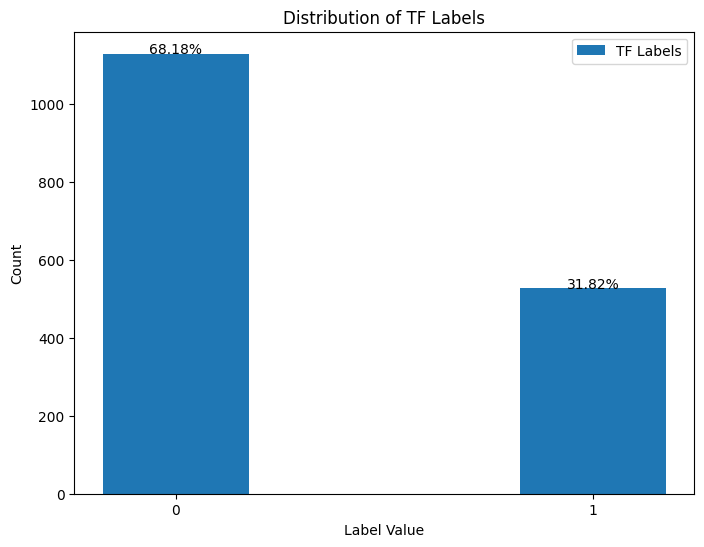

In [14]:
# Count the occurrences of 0 and 1 in TF labels
tf_counts = labels["TF"].value_counts()

# Create bar graph
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
index = range(2)

bar1 = ax.bar(index, tf_counts, bar_width, label='TF Labels')

# Add percentage labels above the bars
total_tf = sum(tf_counts)
tf_percentages = [count / total_tf * 100 for count in tf_counts]
for i, count in enumerate(tf_counts):
    ax.text(i, count + 1, f'{tf_percentages[i]:.2f}%', ha='center')

ax.set_xlabel('Label Value')
ax.set_ylabel('Count')
ax.set_title('Distribution of TF Labels')
ax.set_xticks([i for i in index])
ax.set_xticklabels(['0', '1'])
ax.legend()

plt.show()


### Creating our own validation set

Since the dataset doesn't come with a validation set (a split of the data we can test our model on before making final predicitons on the test set) and a test set, let's make them our selves.

We could use Scikit-Learn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function or we could simply make manual splits of the data.

In [15]:
# splitting the dataset filenames as training, validation, and testing (70%, 15%, 15%)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(image_paths, np.array(labels), test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(1159, 1159, 248, 248, 249, 249)

374 73 80


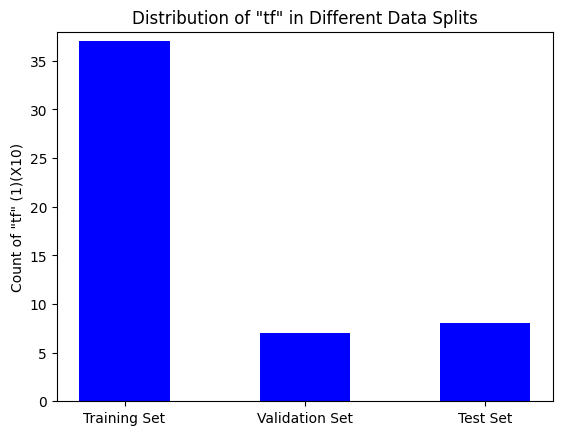

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Count the occurrences of "tf" (1) in y values for each split
train_tf_count = np.sum(np.array(y_train) == 1)
val_tf_count = np.sum(np.array(y_val) == 1)
test_tf_count = np.sum(np.array(y_test) == 1)

# Labels for the bars
labels = ['Training Set', 'Validation Set', 'Test Set']
print(train_tf_count, val_tf_count, test_tf_count)

# Corresponding "tf" counts for each split
tf_counts = [train_tf_count // 10, val_tf_count // 10, test_tf_count // 10]

# Create bar graph
fig, ax = plt.subplots()

bar_width = 0.5

bar1 = ax.bar(labels, tf_counts, bar_width, color='b')

ax.set_ylabel('Count of "tf" (1)(X10)')
ax.set_title('Distribution of "tf" in Different Data Splits')
ax.set_ylim(0, max(tf_counts) + 1)

plt.show()


# **Let's take a look at some of the datasets**

In [17]:
# training dataset
X_train[:5], y_train[:5]

(['drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1155.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1496.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1578.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image236.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image67.jpg'],
 array([[0],
        [0],
        [0],
        [0],
        [0]]))

In [18]:
# Validation dataset
X_val[:5], y_val[:5]

(['drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1076.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1394.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image246.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1051.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1524.jpg'],
 array([[0],
        [1],
        [0],
        [0],
        [0]]))

In [19]:
# testing dataset
X_test[:5], y_test[:5]

(['drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1320.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image715.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image823.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image932.jpg',
  'drive/My Drive/Clear Sight ML Model/dataset/Ethio-Niger-Dataset/image1038.jpg'],
 array([[0],
        [0],
        [0],
        [1],
        [0]]))

## Image Preprocessing Methods

In this section of the code, we define a series of image preprocessing methods that are essential for preparing our image data for machine learning tasks. These methods are applied to each image in our dataset before they are used for training, validation, or testing.

1. **Preprocess Function**:
   - This function takes as input the file path to an image.
   - It reads the image, resizes it to a specified size (224x224 pixels in this case), and decodes it into a TensorFlow tensor.
   - The color channel values of the image are then normalized from the 0-255 range to the 0-1 range.
   - The result is a preprocessed image represented as a TensorFlow tensor, which is suitable for further machine learning tasks.

2. **Get Image Label Function**:
   - This function combines a preprocessed image with its corresponding label.
   - It takes the file path to an image and its associated label as input.
   - Using the `preprocess` function, it preprocesses the image and returns a tuple containing the preprocessed image and its label.

3. **Create Batches Function**:
   - This function is responsible for creating batches of data for training, validation, or testing.
   - It takes a list of image file paths or image data (`X`), an optional list of labels (`y`), the batch size, and a flag indicating whether the data is for testing.
   - For test data, it constructs a TensorFlow dataset with preprocessed images and batches them.
   - For training and validation data, it combines images with their labels using the `get_image_label` function and then batches the data.
   
These image preprocessing steps are essential for standardizing our image data and ensuring that it is in the correct format for training machine learning models. Proper preprocessing contributes to improved model performance and accuracy.


In [20]:
# image preprocessing methods
img_size = 224
def preprocess(img_path):
  """
  Preprocesses an image file.

  Args:
    img_path (str): The path to the image file.

  Returns:
    tf.Tensor: The preprocessed image as a TensorFlow tensor.
  """
  # read the image file
  # image = utils.load_img(img_path, target_size=(img_size, img_size))
  image = tf.io.read_file(img_path)

  # Convert jpg image to tensors
  image = tf.io.decode_jpeg(image, channels=3)

  # Resize it to fixed shape
  image = tf.image.resize(image, [img_size, img_size])

  # Normalize the colour channel value of the image from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)

  return image


# get image, label combination
def get_image_label(img_path, label):
  """
  Combines an image and its corresponding label.

  Args:
    img_path (str): The path to the image file.
    label (int): The label associated with the image.

  Returns:
    tuple: A tuple containing the preprocessed image as a TensorFlow tensor and its label.
  """
  image = preprocess(img_path)
  return image, label


In [21]:
# methods for creating batches for the dataset
def create_batches(X, y=None, batch_size=32, test_data=False):
  """
  Creates batches of data for training, validation, or testing.

  Args:
    X (list or numpy.ndarray): List of image file paths or image data.
    y (None or list or numpy.ndarray): List of labels or None for test data.
    batch_size (int): The batch size.
    test_data (bool): True for test data, False for training/validation data.

  Returns:
    tf.data.Dataset: A TensorFlow dataset containing batches of data.
  """

  if test_data:
    data = tf.data.Dataset.from_tensor_slices(X)
    data = data.map(preprocess).batch(batch_size)
  else:
    data = tf.data.Dataset.from_tensor_slices((X, y))
    data = data.map(get_image_label).batch(batch_size)

  return data


In [22]:
# Now let's create each dataset with a specific batch
training_ds = create_batches(X_train, y_train)
validation_ds = create_batches(X_val, y_val)
testing_ds = create_batches(X_test, y_test)

In [ ]:
training = list(training_ds.as_numpy_iterator())

37

In [ ]:
# the first batch with 32 images
images, labels = next(training_ds.as_numpy_iterator())
images.shape, labels.shape

((32, 224, 224, 3), (32, 1))

In [ ]:
images.dtype

dtype('float32')

In [ ]:
# Displaying some images
def display_image(images, labels, nobs=8, ncols=4):
  """
  Given array of images and their respective labels displays the images using matplotlib
  """
  nrows = nobs//ncols # Number of rows in display

  plt.style.use("default")
  plt.figure(figsize=(4*ncols, 4*nrows))
  for i in range(nrows*ncols):
      ax = plt.subplot(nrows, ncols, i+1)
      plt.imshow(Image.open(X_train[i]))
      plt.title(labels[i], size=10)
      plt.axis('off')

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


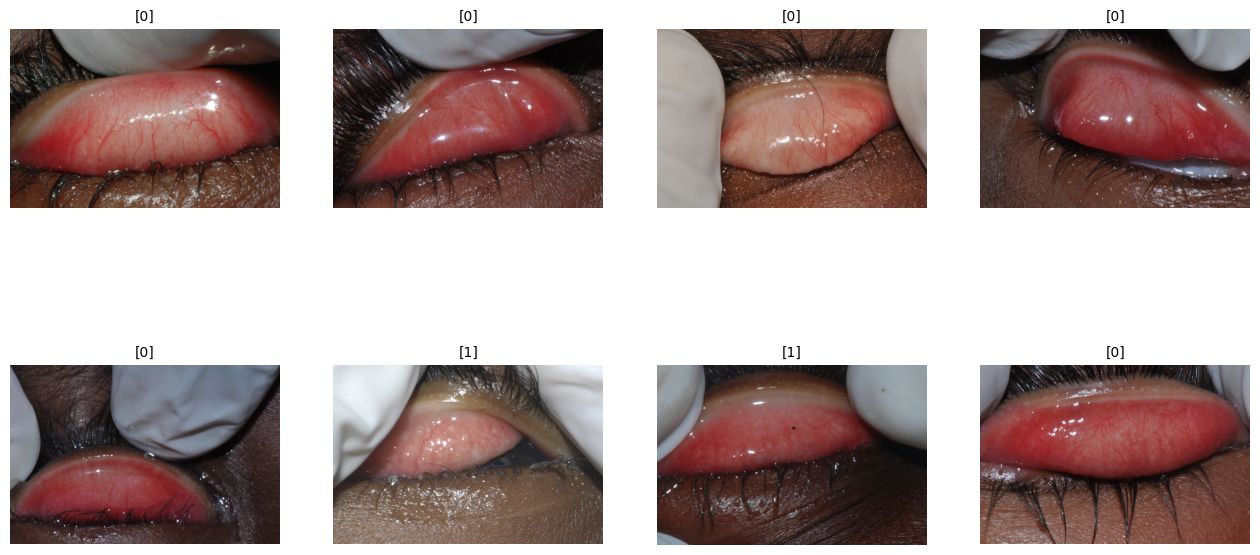

In [ ]:
display_image(images=images, labels=labels);

# Building and Training a Model

### Transfer Learning
1. [imagenet/resnet_v2_152/feature_vector](https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5)
2. [imagenet/mobilenet_v2_140_224/feature_vector](https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/5)
3. [VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16)

In [ ]:
# Tensorflow hub pretrained models
model_url = {
                "resnet": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5",
                "mobilenet": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/5"
            }

In [39]:
num_classes = 2
INPUT_SHAPE = (None, img_size, img_size, 3)

In [ ]:
# create model function
def create_model(model_url):
  # getting the feature extracter from the url
  feature_extracter = hub.KerasLayer(model_url,
                      trainable=False)
  model = tf.keras.Sequential([
      feature_extracter,
      tf.keras.layers.Dense(128, activation='relu'),  # Add a Dense layer
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.Accuracy()]
              )
  model.build(input_shape=INPUT_SHAPE)

  return model

In [ ]:
models = {}
for name, url in model_url.items():
  models[name] = create_model(url)

In [ ]:
# VGG16
vgg16_model = vgg16.VGG16(input_shape=INPUT_SHAPE[1:], include_top=False, weights="imagenet")
vgg16_model.trainable = False

model = tf.keras.Sequential([
    vgg16_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
    )

models["vgg16"] = model

In [ ]:
for name, model in models.items():
  print()
  print(name)
  print(model.summary())


resnet
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              58331648  
                                                                 
 dense_5 (Dense)             (None, 128)               262272    
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 58594049 (223.52 MB)
Trainable params: 262401 (1.00 MB)
Non-trainable params: 58331648 (222.52 MB)
_________________________________________________________________
None

mobilenet
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1792)              4363712   
                           

In [ ]:
# Build a function to train and return a trained model
NUM_EPOCHS = 20 # @param {type:"slider", min:1, max:100, step:1}
def train_model(model, train_data, val_data, name="classifier"):
  """
  Trains a given model and returns the trained version.
  """

  # Fit the model to the data passing it the callbacks we created
  history = model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            # callbacks=[tensorboard, early_stopping]
          )

  # Saveing the model weights
  file_path = f"/content/drive/MyDrive/Clear Sight ML Model/model/{name.upper() + str(time.time())}.h5"
  tf.keras.saving.save_model(model, file_path, save_format="h5")

  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  tflite_model = converter.convert()

  # Save the TFLite model to a file
  tflite_model_file = f"/content/drive/MyDrive/Clear Sight ML Model/model/{name.upper() + str(time.time())}.tflite"
  with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

  return history

In [ ]:
history = {}
for name, model in models.items():
  history[name] = train_model(model, training_ds, validation_ds, name)

Epoch 1/20
37/37 [==============================] - 94s 2s/step - loss: 23.5031 - accuracy: 0.2908 - val_loss: 77.2545 - val_accuracy: 0.2944
Epoch 2/20
37/37 [==============================] - 87s 2s/step - loss: 38.0273 - accuracy: 0.3494 - val_loss: 40.7662 - val_accuracy: 0.2903
Epoch 3/20
37/37 [==============================] - 85s 2s/step - loss: 21.6266 - accuracy: 0.2787 - val_loss: 41.0994 - val_accuracy: 0.2944


In [ ]:
history["vgg16"] = train_model(models["vgg16"], training_ds, validation_ds, name="vgg16")

In [ ]:
history["vgg16"]

In [ ]:
for name , history in history.items():
  print(name)
  print(history.history["accuracy"])

resnet
[0.20189818739891052, 0.07377049326896667, 0.1880931854248047, 0.05953408032655716, 0.21009491384029388, 0.08153580874204636, 0.06859361380338669, 0.06557376682758331, 0.22260569036006927, 0.16738568246364594, 0.08455564826726913, 0.08757549524307251, 0.07592752575874329, 0.0780845582485199, 0.05090595409274101, 0.10224331170320511, 0.0974978432059288, 0.1436583250761032, 0.16479723155498505, 0.08843830972909927, 0.07851596176624298, 0.10569456219673157, 0.1363244205713272, 0.07635892927646637, 0.11518550664186478]
mobilenet
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
vgg16
[0.5729076862335205, 0.572044849395752, 0.5685936212539673, 0.5737704634666443, 0.5746333003044128, 0.5711820721626282, 0.5754961371421814, 0.5772217512130737, 0.5772217512130737, 0.5780845284461975, 0.5780845284461975, 0.581535816192627, 0.581535816192627, 0.5823985934257507, 0.5832614302635193, 0.5858498811721802, 0.5867126584

# **Evaluating the Models**

In [ ]:
# Evaluating the models with the training models
for name, model in models.items():
  print(model.evaluate(training_ds))

In [ ]:
# Saving the models
import time
for name, model in models.items():
  tf.keras.saving.save_model(model, f"/drive/MyDrive/Clear Sight ML Model/model/{name.upper() + str(time.time())}.tf")

In [38]:
path = "/content/drive/MyDrive/Clear Sight ML Model/model/VGG161697220795.0430205.h5"
loaded_model = tf.keras.models.load_model(path)
for imgs, lbls in training_ds.take(1):
  print(loaded_model.predict(imgs))

1/1 [==============================] - 0s 301ms/step
[[0.0010516 ]
 [0.06704661]
 [0.04162377]
 [0.18337429]
 [0.18104008]
 [0.51569843]
 [0.06367565]
 [0.14493132]
 [0.12444003]
 [0.5696918 ]
 [0.01845977]
 [0.7403507 ]
 [0.14043318]
 [0.5778757 ]
 [0.02679116]
 [0.37969857]
 [0.01637492]
 [0.79284704]
 [0.03687547]
 [0.18713692]
 [0.14986497]
 [0.28894895]
 [0.03554371]
 [0.5697714 ]
 [0.30016175]
 [0.07766913]
 [0.29783756]
 [0.2695012 ]
 [0.0088826 ]
 [0.00779974]
 [0.05062621]
 [0.6083372 ]]
